<a href="https://colab.research.google.com/github/cavannus/ttow-ML/blob/main/wayang_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unzip the dataset. The dataset contains 4 classes and needs to be split into train and validation later.

In [1]:
import os
import zipfile

# local_zip = '/content/wayang-edited-final.zip'
local_zip = '/content/wayang-final-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [2]:
base_dir = '/content/augmented/'

In [3]:
IMG_WIDTH = 175
IMG_HEIGHT = 225

IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = IMG_SIZE + (3,)

In [4]:
import tensorflow as tf

In [5]:
train_batch = 40
train_epoch = 80
val_batch = 40
val_epoch = 20

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                  #  horizontal_flip = True,
                                  #  width_shift_range = 0.1,
                                  #  height_shift_range = 0.1,
                                  #  fill_mode = 'nearest',
                                  #  rotation_range=15,
                                  #  zoom_range=0.2,
                                   validation_split=0.2
                                   )


train_generator = train_datagen.flow_from_directory(base_dir,
                                                    batch_size=train_batch,
                                                    class_mode='categorical',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    subset='training')     

validation_generator =  train_datagen.flow_from_directory(base_dir,
                                                         batch_size=val_batch,
                                                         class_mode='categorical',
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         shuffle=True,
                                                         subset='validation')


Found 3575 images belonging to 4 classes.
Found 893 images belonging to 4 classes.


In [20]:
labels_dict = train_generator.class_indices
wayang_labels = dict((v, k) for k, v in labels_dict.items())
print(wayang_labels)

{0: 'bagong', 1: 'gareng', 2: 'petruk', 3: 'semar'}


In [ ]:
import os

dataset_counts = []
total_dataset_count = 0

for root, _, fileList in os.walk('./augmented/'):
    for _, label in wayang_labels.items():
        if label in root:
            dataset_counts.append(len(fileList))
            total_dataset_count += len(fileList)

print(dataset_counts, total_dataset_count)

[1120, 1040, 1208, 1100] 4468


Since we are working with imbalanced dataset, we will use class weights in the model.

In [7]:
import sklearn
import numpy as np

# class_weight_list = sklearn.utils.class_weight.compute_class_weight('balanced',
#                                                                np.unique(train_generator.classes),
#                                                                train_generator.classes)

# class_weights = {}

# for k, _ in wayang_labels.items():
#   class_weights[k] = class_weight_list[k]

class_weights = {0: 0.9147058823529411, 1: 1.4136363636363636, 2: 1.0798611111111112, 3: 0.7853535353535354}

print(class_weights)

{0: 0.9147058823529411, 1: 1.4136363636363636, 2: 1.0798611111111112, 3: 0.7853535353535354}


This part defines the model used for transfer learning, which is MobileNetV2.

In [32]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# base_model.summary()

Fine tuning on MobileNet by unfreezing the first 75 layer of the model

In [33]:
base_model.trainable = True

for layer in base_model.layers[:25]:
  layer.trainable = False

In [34]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dense(16)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 175, 225, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                20496     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112

In [36]:
class Acc_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if logs['accuracy'] > 0.95:
      print('\nAccuracy is more than 95%')
      self.model.stop_training = True
    elif logs['val_accuracy'] > 0.95:
      print('\nVal-Accuracy is more than 95%')
      self.model.stop_training = True

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=1e-5, patience=5)

callbacks = [Acc_Callback(),
            #  earlyStop,
             ]

In [37]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_batch,
                    epochs=train_epoch,
                    validation_steps=val_epoch,
                    verbose=2,
                    callbacks=callbacks,
                    class_weight=class_weights)

Epoch 1/80
40/40 - 9s - loss: 2.4622 - accuracy: 0.2546 - val_loss: 1.8685 - val_accuracy: 0.2188
Epoch 2/80
40/40 - 5s - loss: 2.1846 - accuracy: 0.2775 - val_loss: 1.7746 - val_accuracy: 0.2125
Epoch 3/80
40/40 - 5s - loss: 2.0072 - accuracy: 0.2894 - val_loss: 1.7361 - val_accuracy: 0.2250
Epoch 4/80
40/40 - 5s - loss: 2.0242 - accuracy: 0.2927 - val_loss: 1.6456 - val_accuracy: 0.2400
Epoch 5/80
40/40 - 5s - loss: 1.9135 - accuracy: 0.3175 - val_loss: 1.5844 - val_accuracy: 0.2562
Epoch 6/80
40/40 - 5s - loss: 1.8459 - accuracy: 0.3094 - val_loss: 1.5460 - val_accuracy: 0.2450
Epoch 7/80
40/40 - 5s - loss: 1.7161 - accuracy: 0.3344 - val_loss: 1.5167 - val_accuracy: 0.2512
Epoch 8/80
40/40 - 5s - loss: 1.6568 - accuracy: 0.3524 - val_loss: 1.4649 - val_accuracy: 0.2763
Epoch 9/80
40/40 - 5s - loss: 1.5786 - accuracy: 0.3550 - val_loss: 1.4268 - val_accuracy: 0.2937
Epoch 10/80
40/40 - 5s - loss: 1.5558 - accuracy: 0.3448 - val_loss: 1.3956 - val_accuracy: 0.3013
Epoch 11/80
40/40 -

Text(0.5, 1.0, 'Training and validation loss')

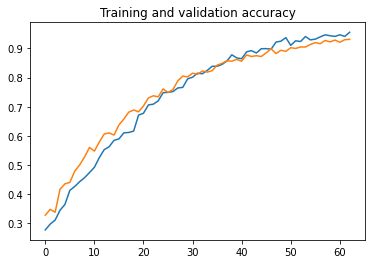

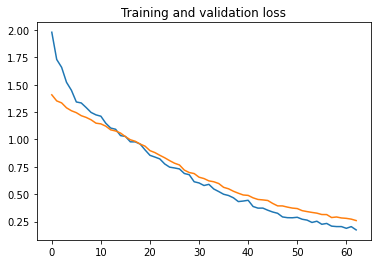

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title ('Training and validation loss')

In [41]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes_pred = model.predict(images, batch_size=10)
  wayang_class = np.argmax(classes_pred)

  print('{} is {}'.format(fn, wayang_labels[wayang_class]))
  print(classes_pred)

Saving petruk (1).jpg to petruk (1).jpg
Saving petruk (4).jpg to petruk (4).jpg
Saving petruk (17).jpg to petruk (17).jpg
petruk (1).jpg is petruk
[[0.18348353 0.04195826 0.42582604 0.3487322 ]]
petruk (4).jpg is semar
[[0.20168176 0.2539061  0.1686401  0.375772  ]]
petruk (17).jpg is gareng
[[0.17481984 0.45316675 0.08084717 0.2911662 ]]


In [15]:
test_zip = '/content/wayang-test.zip'

zip_ref = zipfile.ZipFile(test_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [39]:
test_dir = '/content/test'

test_generator = train_datagen.flow_from_directory(test_dir,
                                                   batch_size=1,
                                                   class_mode='categorical',
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH)) 

Found 120 images belonging to 4 classes.


In [40]:
model.evaluate(test_generator,
               batch_size=1,
               steps=120,
               verbose=1)

120/120 [==============================] - 1s 8ms/step - loss: 0.3313 - accuracy: 0.9000


[0.33130285143852234, 0.8999999761581421]

In [ ]:
modelBaseName = 'wayang-mobilenet-v4'
modelTFLite = modelBaseName + '.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(modelTFLite, 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpl_kwrz9f/assets


In [ ]:
from google.colab import files

files.download(modelTFLite)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>